This is a notebook to demonstrate how to use the tools in demNet to request 3DEP point clouds from cloud hosted services provided by the USGS, turn those point clouds into grids, and produce derivatives

In [3]:
import sys
import os
sys.path.append('demCreationComponents/')

import pointCloudCreation as pCC

from matplotlib import pyplot as plt
import numpy as np

from importlib import reload

**Requesting point cloud profiles and fitting scarps**

Let's use pdal and entwine to request profiles normal to the trace of a fault scarp. We will request multiple orthogonal profiles at a regular spacing along a scarp. We will then fit a simple functional form to each of these:

$$z(L,kt) = A erf(\frac{L}{2*\sqrt{kt}}) + bL + c $$

$b$ [] is the inclination of the surface that was offset, $A$ is the half-magnitude of the original offset, $L$ is the distance from the scarp, and $kt$ [m$^2$] is the "morphologic age" (e.g., the product of the linear diffusivity, $k$, and the time since faulting $t$. We add $c$ [m] because our example here isn't centered at 0 elevation.

In [5]:
#First lets load in a trace of the fault scarp above
import geopandas as gpd

#What is the name of the dataset we are requesting from? Found at: https://usgs.entwine.io/
usgs_survey_name = 'CO_San-Luis-Valley_2011'

#Where do we have a fault scarp stored?
pathToFaultTrace = os.path.join('testData','vectorData','SLV_Zapata_FaultScarp.shp')
outEPSG = 32613 #EPSG code of WGS84 zone 13N

fsGDF = gpd.read_file(pathToFaultTrace)

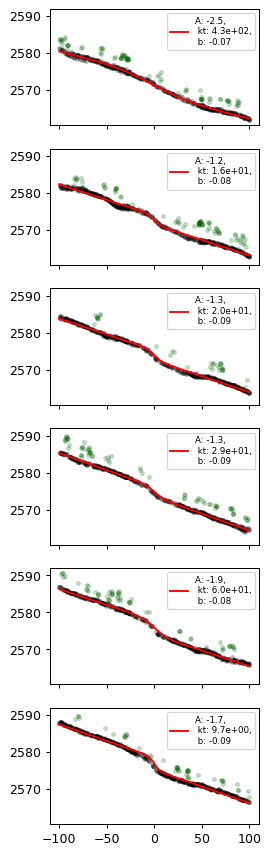

In [12]:
#Here we will request a series of orthogonal profiles to the line above
from scipy.special import erf
from scipy import optimize
from importlib import reload
reload(pCC)

nSwaths = 6 #Number of orthogonal profiles we will construct
swathPositions = np.linspace(0,1,nSwaths) #Relative positions along the line of the swaths, no profiles drawn at start and end

faultLine = fsGDF.geometry[0] #Get the line geometry

#How long and wide is each fault swath
swathLength = 200.0
swathWidth = 3.0

f,axs = plt.subplots(nSwaths,1,figsize = (3,2*nSwaths),dpi = 90,sharex = True,sharey = True)


plotInterval = 5 #Plot every nth pointcloud point (reduces figure complexity)

#Create some functions for fitting fault scarp morphology
def fsFun(L,params):
    #Solution for an initially vertical scarp on an inclined surface smoothed by linear diffusion
    a,kt,b,c = params #Split out out parameters to they are easy to read
    return a*erf((L)/(2.0*np.sqrt(kt))) + b*(L) + c #Calculate z(L,kt) in the above

def fitFS(L,Z):
    #Optimizing for the best fitting paramaters in the above scarp profile solution
    objFun = lambda params : np.sum((Z - fsFun(L,params))**2) #Objective function is simple sum of squared errors
    paramGuess = [1.0,10,0.0,np.mean(Z)] #Make simple, constant initial guess
    
    res = optimize.minimize(objFun,paramGuess).x #Find the parameters that were found to minimize the objective function
    return res


for i,relative_position in enumerate(swathPositions[:]):
    
    
    #Execute the pipeline
    pipe = pCC.get_orthogonal_swathprofile_request_pointcloud(faultLine,
                                                             relative_position, swathLength,
                                                             swathWidth,outEPSG,
                                                             usgs_survey_name,
                                                             'profileTest',doSavePointCloud=False,
                                                            doReclassify = True)
    #Get the relevant data from the pipeline
    arrays = pipe.arrays[0]
    L = np.array(arrays['L']) - swathLength/2.0
    Z = np.array(arrays['Z'])
    C = np.array(arrays['Classification'])
    D = np.array(arrays['D'])
    X = np.array(arrays['X'])
    Y = np.array(arrays['Y'])
    
    #Which points are ground:
    isGrnd = C == 2
    
    #Fit the fault scarp
    bfParams = fitFS(L[isGrnd],Z[isGrnd])
    
    #Create a predicted FS line
    LtoFit = np.linspace(-swathLength/2.0,swathLength/2.0,50)
    Zfit = fsFun(LtoFit,bfParams)
    
    #Plot the result
    axs[i].plot(L[~isGrnd][::plotInterval],Z[~isGrnd][::plotInterval],'.',color = 'darkgreen',alpha =0.2) # Not ground points
    axs[i].plot(L[isGrnd][::plotInterval],Z[isGrnd][::plotInterval],'.',color = 'k',alpha =0.2) #ground points
    axs[i].plot(LtoFit,Zfit,'-r',label = 'A: {:.1f},\n kt: {:.1e},\n b: {:.2f}'.format(bfParams[0],bfParams[1],bfParams[2]))
    
    axs[i].legend(fontsize = 'x-small')
    

plt.savefig("fitscarps.png")

**Some things to consider**

1. How might we update the 'model' fault scarp to use a non-linear solution? How could we create the code to be flexible for different fault scarp models?

2. Note the wide variation in morphologic age (and to a smaller extent amplitude) from a single scarp. How might we characterize what variations are real geologic differences vs. error/uncertainty in our model-fits?

3. These profiles have small, subtle rises in the opposite sense of the main scarp around the 50 m mark. Perhaps these are small grabens? These seem to be impacting our model fits - how might we minimize that impact?